# DATA EXPLORATION

### Assignment information

ADSS have just been awarded a contract by a government department (the Department of Environment) to help with the development of machine learning-based models for predicting atmospheric emissions (and pollution) from data gathered by various borough and county environment monitoring units.

Access the following URL:

https://data.london.gov.uk/dataset/london-atmospheric-emissions-inventory-2013

The web page describes the various types of data held for monitored atmospheric emissions for the year 2013. Note that ADSS will ultimately be working on datasets compiled over a 50-year period, but you will be focusing only on a single year (2013), in the first instance, when developing the ML models.

### London Datastore

LAEI is a database of geographically referenced datasets of pollutant emissions in greater london

A full inventory of london's emissions by source and locations for 2013


Estimates of key pollutants (NOx, PM10, PM2.5 and CO2) are included for the base year 2013 and projected forward to 2020, 2025, and 2030. Emissions for previous years 2008 and 2010 are also provided, to allow comparison with previous versions of the LAEI.

The LAEI area covers the 32 London Boroughs and the City of London and up to the M25 motorway

Due to the size of the LAEI database this dataset has been zipped and needs to be downloaded in several parts.

File structure

0. methodology - pdf
1. road traffic flows and vehicle kilometers
    toid, grid cut, location exact cut and borough
    annual average daily traffic and vehicle kilometers
2. grid emissions summary
    emissions summaries for:
     * CO2
     * NOx
     * PM2.5
     * PM10
     * other pollutants (so2, NMVOC, 1,3 butadiene, ammonia, benzene, carbon monoxide, methane, nitrous oxide, cadmium, mercury, lead, benzo[a]pyrene, polychlorinated biphenyl, hydrogen chloride)
    data presented by grid exact cut, has LAEI 1km2di, grid exactcut_id,easting, northing, borough, zone, pollutant source
    tones/year
3. road emissions summary
    - 2 sheets - lts rds and other major roads
    - has grid exact cut
    - has emissions by vehicle type - could comare traffic flows to and vkm to pollutant emissions
    - has ploutants - co2, nox, pm10, pm25 - latter through brake exhaust tyres resusp
    - grid cut again, toid borough, road length
    - total road length in borough may be useful>
    - is this duplicated through grid em summary?
4. polutants by coordinate in concentration
   - ignore - replace with 4.1
    - file mislabled as n02 not co2
4. 1. pollutants by coordinate in concentration
    - no2 possibly mislabled
    - concentration by coordinates - could map to gridcut

## 1. Road traffic data

same data in excel and gis format

There are two worksheets in the file:

* for major roads:
  - aadt = annual average daily traffic
  - average traffic speed 
  - road length
  - vehicle kilometers (vkm)= aadt * link length
  - data at link level and multiple entries per grid cut

* for minor roads:
  - traffic speed
  - vkm
  - data seems to be aggregated by grid cut - i.e. one entry per grid cut

In order to join the data will need to be aggregated by grid cut
To have like data for major and minor roads will mean using average traffic speed and vhk
    This means aadt and road length should be dropped to avoid colinearity (aadt * road length = vkm)

aggregated by grid_exactcut_ID




In [1]:
# required to open excel worksheets
%pip install openpyxl
%pip install pyxlsb
%pip install xlrd


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from pyxlsb import open_workbook as open_xlsb
from scipy.spatial import KDTree



### MajorGrid_AADTandVKM_2013

In [3]:
# set datset  filepath for  personal directory
datasetfile_path = '/Users/josephpassant/eom_data_exp_and_cleaning/dataset'

# file extension - no need to change if using the same dataset
file_extension = '/1. Supporting Information - incl. traffic data/1. Road Traffic Data/Excel/LAEI2013_2013_AADT-VKM.xlsx'


road_traffic_major = pd.read_excel(datasetfile_path + file_extension, sheet_name='MajorGrid_AADTandVKM_2013')
road_traffic_major.head()


,RowID,Year,Toid,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,TLRN,MotorwayNumber,AADT Motorcycle,AADT Taxi,...,VKM_Coach,VKM_Rigid2Axle,VKM_Rigid3Axle,VKM_Rigid4Axle,VKM_Artic3Axle,VKM_Artic5Axle,VKM_Artic6Axle,VKM_ElectricCar,VKM_ElectricLgv,VKM_TOTAL
0,1415.0,2013.0,4.000000e+15,2.0,External,NonGLA,Other,M25,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00
1,1416.0,2013.0,4.000000e+15,2.0,External,NonGLA,Other,M25,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00
2,1417.0,2013.0,4.000000e+15,2.0,External,NonGLA,Other,M25,108.236168,227.767231,...,4035.770739,38260.919886,8307.161466,5818.844182,4753.084665,15244.331077,57754.407669,0.0,0.0,1.478443e+06
3,1418.0,2013.0,4.000000e+15,2.0,External,NonGLA,Other,M25,108.236168,227.767231,...,12221.857971,115868.704874,25157.263421,17621.686599,14394.158999,46165.667315,174902.444514,0.0,0.0,4.477292e+06
4,1420.0,2013.0,4.000000e+15,2.0,External,NonGLA,Other,M25,108.236168,227.767231,...,11567.120094,109661.495622,23809.562172,16677.674182,13623.048655,43692.523617,165532.735299,0.0,0.0,4.237439e+06


In [4]:
road_traffic_major.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87999 entries, 0 to 87998
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RowID                 87996 non-null  float64
 1   Year                  87996 non-null  float64
 2   Toid                  87996 non-null  float64
 3   GRID_ExactCut_ID      87996 non-null  float64
 4   Location_ExactCut     87996 non-null  object 
 5   BoroughName_ExactCut  87996 non-null  object 
 6   TLRN                  87996 non-null  object 
 7   MotorwayNumber        87996 non-null  object 
 8   AADT Motorcycle       87996 non-null  float64
 9   AADT Taxi             87996 non-null  float64
 10  AADT Pcar             87996 non-null  float64
 11  AADT Dcar             87996 non-null  float64
 12  AADT PLgv             87996 non-null  float64
 13  AADT DLgv             87996 non-null  float64
 14  AADT LtBus            87996 non-null  float64
 15  AADT Coach         

* As above aadt columns and length should be dropped to avoid colinearity
* VKMTOTAL should be dropped as it is a sum of each vehicle type VKM so will be colinear
* Toid should be dropped as it is a unique identifier for each road
* Formatting of column titles is required
  * use consistent case
    * easiest to convert to CamelCase
* There are very few null values
* The datatype is primarily float64


In [5]:
# drop columns that contain the strings AADT or Length in their column name
road_traffic_major = road_traffic_major.drop(road_traffic_major.filter(like='AADT').columns, axis=1)
road_traffic_major= road_traffic_major.drop(road_traffic_major.filter(like='Length').columns, axis=1)
# drop Year Toid and vkmtotal columns
road_traffic_major = road_traffic_major.drop('Year', axis=1)
road_traffic_major = road_traffic_major.drop('Toid', axis=1)
road_traffic_major = road_traffic_major.drop('VKM_TOTAL', axis=1)

In [6]:
#remove spaces and underscores to convert column titles to CamelCase
def clean_column_titles(df):
    'convert column titles to CamelCase'
    df.columns = df.columns.str.replace(' ', '')
    df.columns = df.columns.str.replace('_', '')
    df.columns = df.columns.str.replace('(', '', regex=False)
    df.columns = df.columns.str.replace(')', '', regex=False)
    df.columns = df.columns.str.strip()

clean_column_titles(road_traffic_major)

In [7]:
road_traffic_major.nunique()

RowID                  87996
GRIDExactCutID          2820
LocationExactCut           4
BoroughNameExactCut       34
TLRN                       2
MotorwayNumber             8
Speedkph               52746
VKMMotorcycle          82451
VKMTaxi                82400
VKMPcar                84213
VKMDcar                84213
VKMPLgv                83851
VKMDLgv                83851
VKMLtBus               64793
VKMCoach               46458
VKMRigid2Axle          82980
VKMRigid3Axle          78080
VKMRigid4Axle          79350
VKMArtic3Axle          72631
VKMArtic5Axle          76648
VKMArtic6Axle          74061
VKMElectricCar         83089
VKMElectricLgv         82726
dtype: int64

* It is known there are 3355 GridExactCutID's in the dataset therefore not all are represented in this file
* 2820 unique grid cuts but 87999 rows therefore there are multiple entries per grid cut
  * If planning to merge on grid cut will need to aggregate data
  * This will result in loss of non-numeric data from this file
    * LocationExactCut, BoroughNameExactCut, TLRN and  MotorwayNumber
      * GridExactCutID, LocationExactCutID, BoroughNameExactCutID are all area identifiers
        * keeping all of these will result in colinearity
        * GridExactCutID in numeric and most granular so will keep this
        * Therefore nothing is lost through dropping LocationExactCutID and BoroughNameExactCutID
      * TLRN only has two unique values so predictive value may be limited

In [8]:
# count the number of duplicate rows
road_traffic_major.duplicated().sum()

1

In [9]:
# show duplicated rows
road_traffic_major[road_traffic_major.duplicated(keep=False)]

,RowID,GRIDExactCutID,LocationExactCut,BoroughNameExactCut,TLRN,MotorwayNumber,Speedkph,VKMMotorcycle,VKMTaxi,VKMPcar,...,VKMLtBus,VKMCoach,VKMRigid2Axle,VKMRigid3Axle,VKMRigid4Axle,VKMArtic3Axle,VKMArtic5Axle,VKMArtic6Axle,VKMElectricCar,VKMElectricLgv
87996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* There are is one duplicated row in the dataset
  * The duplicated rows are all NaN values and therefore can be dropped

In [10]:
# Drop rows with index 87996 and 87997 (NaN values)
road_traffic_major.drop([87996, 87997], inplace=True)
# Drop RowID column
road_traffic_major.drop('RowID', axis=1, inplace=True)

In [11]:
# separate speed from df and group by GRIDExactCutID to get average speed in each grid
# needs to be separated as other values will be summed
grid_cut_average_speedkph = road_traffic_major[['GRIDExactCutID', 'Speedkph']]
grid_cut_average_speedkph = grid_cut_average_speedkph.groupby('GRIDExactCutID').mean(numeric_only=True).reset_index()
# group by GRID_ExactCut_ID, summing values
road_traffic_major_grouped = road_traffic_major.drop('Speedkph', axis=1)
road_traffic_major_grouped = road_traffic_major.groupby('GRIDExactCutID').sum(numeric_only=True).reset_index()
# merge average speed back into df
road_traffic_major_grouped = pd.merge(road_traffic_major_grouped, grid_cut_average_speedkph, on='GRIDExactCutID', how='left')
road_traffic_major_grouped.head()


,GRIDExactCutID,Speedkph_x,VKMMotorcycle,VKMTaxi,VKMPcar,VKMDcar,VKMPLgv,VKMDLgv,VKMLtBus,VKMCoach,VKMRigid2Axle,VKMRigid3Axle,VKMRigid4Axle,VKMArtic3Axle,VKMArtic5Axle,VKMArtic6Axle,VKMElectricCar,VKMElectricLgv,Speedkph_y
0,2.0,3955.760122,319444.228860,332668.490263,2.760651e+07,2.583487e+07,223134.691298,8.287918e+06,133387.356224,227940.774761,1.386956e+06,314179.413266,278980.291417,186896.469373,479078.648066,1.945731e+06,5974.926505,1551.726724,91.994421
1,3.0,2604.873235,86705.716265,155161.422264,1.186193e+07,1.308050e+07,114747.601479,3.894011e+06,14817.305355,87195.481133,8.136928e+05,164412.267533,143412.776470,96825.955970,354679.898643,1.348066e+06,753.307705,185.293243,68.549296
2,7.0,1062.178803,100388.899575,167671.175259,1.136762e+07,1.293197e+07,110195.598112,3.673127e+06,0.000000,67310.851847,9.322686e+05,133302.397823,170808.811020,104402.105929,498043.742444,1.876257e+06,358.571356,67.399367,53.108940
3,8.0,1052.025671,148477.032344,221895.635251,1.596811e+07,1.854269e+07,176784.733469,5.845628e+06,0.000000,130616.278550,1.233269e+06,260336.512803,264140.129823,154544.808633,756137.181505,2.641195e+06,158.134888,29.724045,58.445871
4,9.0,438.504691,212755.783601,281037.390661,2.074281e+07,2.431121e+07,213873.240120,7.050407e+06,0.000000,164281.001485,1.220320e+06,293038.687487,216705.892617,160329.267522,465054.903774,2.118667e+06,0.207283,0.000000,87.700938


In [12]:
# unsure why Speedkph_x is created, drop it
road_traffic_major_grouped.drop('Speedkph_x', axis=1, inplace=True)
clean_column_titles(road_traffic_major_grouped)

In [13]:
# append MjRd to end of  column name for columns [1:]

road_traffic_major_grouped.columns.values[1:] = [str(col) + 'MjRd' for col in road_traffic_major_grouped.columns[1:]]

In [14]:
road_traffic_major_grouped.head()

,GRIDExactCutID,VKMMotorcycleMjRd,VKMTaxiMjRd,VKMPcarMjRd,VKMDcarMjRd,VKMPLgvMjRd,VKMDLgvMjRd,VKMLtBusMjRd,VKMCoachMjRd,VKMRigid2AxleMjRd,VKMRigid3AxleMjRd,VKMRigid4AxleMjRd,VKMArtic3AxleMjRd,VKMArtic5AxleMjRd,VKMArtic6AxleMjRd,VKMElectricCarMjRd,VKMElectricLgvMjRd,SpeedkphyMjRd
0,2.0,319444.228860,332668.490263,2.760651e+07,2.583487e+07,223134.691298,8.287918e+06,133387.356224,227940.774761,1.386956e+06,314179.413266,278980.291417,186896.469373,479078.648066,1.945731e+06,5974.926505,1551.726724,91.994421
1,3.0,86705.716265,155161.422264,1.186193e+07,1.308050e+07,114747.601479,3.894011e+06,14817.305355,87195.481133,8.136928e+05,164412.267533,143412.776470,96825.955970,354679.898643,1.348066e+06,753.307705,185.293243,68.549296
2,7.0,100388.899575,167671.175259,1.136762e+07,1.293197e+07,110195.598112,3.673127e+06,0.000000,67310.851847,9.322686e+05,133302.397823,170808.811020,104402.105929,498043.742444,1.876257e+06,358.571356,67.399367,53.108940
3,8.0,148477.032344,221895.635251,1.596811e+07,1.854269e+07,176784.733469,5.845628e+06,0.000000,130616.278550,1.233269e+06,260336.512803,264140.129823,154544.808633,756137.181505,2.641195e+06,158.134888,29.724045,58.445871
4,9.0,212755.783601,281037.390661,2.074281e+07,2.431121e+07,213873.240120,7.050407e+06,0.000000,164281.001485,1.220320e+06,293038.687487,216705.892617,160329.267522,465054.903774,2.118667e+06,0.207283,0.000000,87.700938


In [15]:
# create dataframe dict

df_dict = {}

df_dict['road_traffic_major_grouped'] = road_traffic_major_grouped

### MinorGrid_VKM_2013

In [16]:
road_traffic_minor = pd.read_excel(datasetfile_path + file_extension, sheet_name='MinorGrid_VKM_2013')
road_traffic_minor.head()

,Year,ID,GRID_ExactCut_ID,Location_ExactCut,BoroughName_ExactCut,Easting,Northing,speed (kph),VKM_Motorcycle,VKM_Taxi,...,VKM_Coach,VKM_Rigid,VKM_Artic,VKM_Petrolcar,VKM_Dieselcar,VKM_Electriccar,VKM_Petrollgv,VKM_Diesellgv,VKM_Electriclgv,VKM_Total
0,2013,5910,1,External,NonGLA,510500,203500,30,7223.168225,3303.116745,...,4513.072361,7680.054517,853.427764,309599.517097,183701.922502,164.155952,1083.285552,54429.435225,31.158503,572582.314443
1,2013,5911,2,External,NonGLA,511500,203500,30,4742.141375,2167.935313,...,2962.995481,5041.590112,559.699517,203270.767843,120611.398853,107.778290,711.243897,35736.287198,20.457482,375932.295360
2,2013,5912,3,External,NonGLA,512500,203500,30,7278.285529,3327.995491,...,4548.852095,7740.195812,860.663552,312015.145930,185135.244055,165.436767,1091.752757,54854.868005,31.402045,577049.842037
3,2013,5915,4,External,NonGLA,515500,203500,30,7204.224780,3294.143071,...,4499.043482,7654.621079,847.495192,308578.002296,183095.803234,163.614324,1079.683190,54248.435380,31.054888,570696.120915
4,2013,5916,5,External,NonGLA,516500,203500,30,6499.471249,2972.477278,...,4057.870123,6911.448474,766.513286,278614.894550,165317.091727,147.727276,974.893390,48983.295782,28.040823,515273.723959


In [17]:
road_traffic_minor.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  3355 non-null   int64  
 1   ID                    3355 non-null   int64  
 2   GRID_ExactCut_ID      3355 non-null   int64  
 3   Location_ExactCut     3355 non-null   object 
 4   BoroughName_ExactCut  3355 non-null   object 
 5   Easting               3355 non-null   int64  
 6   Northing              3355 non-null   int64  
 7   speed (kph)           3355 non-null   int64  
 8   VKM_Motorcycle        3355 non-null   float64
 9   VKM_Taxi              3355 non-null   float64
 10  VKM_Bus               3355 non-null   float64
 11  VKM_Coach             3355 non-null   float64
 12  VKM_Rigid             3355 non-null   float64
 13  VKM_Artic             3355 non-null   float64
 14  VKM_Petrolcar         3355 non-null   float64
 15  VKM_Dieselcar        

* Year column should be dropped as it is all 2013
* Formatting of column titles is required
* There are no null values
* The datatype is primarily int64 or float64 i.e. numeric

In [18]:
# Drop Year and VKM_TOTAL column
road_traffic_minor = road_traffic_minor.drop('Year', axis=1)
road_traffic_minor = road_traffic_minor.drop('ID', axis=1)
road_traffic_minor = road_traffic_minor.drop('Location_ExactCut', axis=1)
road_traffic_minor = road_traffic_minor.drop('VKM_Total', axis=1)


In [19]:
# clean column titles
clean_column_titles(road_traffic_minor)
road_traffic_minor.head(10)

,GRIDExactCutID,BoroughNameExactCut,Easting,Northing,speedkph,VKMMotorcycle,VKMTaxi,VKMBus,VKMCoach,VKMRigid,VKMArtic,VKMPetrolcar,VKMDieselcar,VKMElectriccar,VKMPetrollgv,VKMDiesellgv,VKMElectriclgv
0,1,NonGLA,510500,203500,30,7223.168225,3303.116745,0.0,4513.072361,7680.054517,853.427764,309599.517097,183701.922502,164.155952,1083.285552,54429.435225,31.158503
1,2,NonGLA,511500,203500,30,4742.141375,2167.935313,0.0,2962.995481,5041.590112,559.699517,203270.767843,120611.398853,107.778290,711.243897,35736.287198,20.457482
2,3,NonGLA,512500,203500,30,7278.285529,3327.995491,0.0,4548.852095,7740.195812,860.663552,312015.145930,185135.244055,165.436767,1091.752757,54854.868005,31.402045
3,4,NonGLA,515500,203500,30,7204.224780,3294.143071,0.0,4499.043482,7654.621079,847.495192,308578.002296,183095.803234,163.614324,1079.683190,54248.435380,31.054888
4,5,NonGLA,516500,203500,30,6499.471249,2972.477278,0.0,4057.870123,6911.448474,766.513286,278614.894550,165317.091727,147.727276,974.893390,48983.295782,28.040823
5,6,NonGLA,517500,203500,30,18313.730852,8372.531995,0.0,11441.662661,19468.876439,2163.297783,784903.808240,465725.334150,416.171941,2746.376666,137991.068504,78.993931
6,7,NonGLA,518500,203500,30,19680.613936,8998.042773,0.0,12296.970326,20922.256777,2324.881631,843495.530355,500490.930997,447.238462,2951.381308,148291.479929,84.890472
7,8,NonGLA,519500,203500,30,5697.308720,2605.427706,0.0,3559.524189,6057.278512,672.800520,244196.556929,144894.854478,129.477974,854.438048,42931.044622,24.576170
8,9,NonGLA,508500,202500,30,6575.170858,3005.291511,0.0,4107.703118,6988.799024,776.257575,281741.318772,167172.166132,149.384969,985.769087,49529.742678,28.353640
9,10,NonGLA,509500,202500,30,13249.280222,6057.702334,0.0,8277.917960,14084.393303,1564.713267,567840.258241,336929.941271,301.080438,1986.876861,99830.174214,57.148466


In [20]:
road_traffic_minor.nunique()

GRIDExactCutID         3355
BoroughNameExactCut      34
Easting                  61
Northing                 52
speedkph                  5
VKMMotorcycle          3127
VKMTaxi                3127
VKMBus                 1839
VKMCoach               2417
VKMRigid               3127
VKMArtic               3127
VKMPetrolcar           3127
VKMDieselcar           3127
VKMElectriccar         3127
VKMPetrollgv           3127
VKMDiesellgv           3127
VKMElectriclgv         3127
dtype: int64

* ID appears a unique identifier for each row so can be dropped

In [21]:
# count the number of duplicate rows
road_traffic_minor.duplicated().sum()

0

In [22]:
# append MnRd to end of  column name for columns [1:]
road_traffic_minor.columns.values[5:] = [str(col) + 'MnRd' for col in road_traffic_minor.columns[5:]]

In [23]:
road_traffic_minor.head()

,GRIDExactCutID,BoroughNameExactCut,Easting,Northing,speedkph,VKMMotorcycleMnRd,VKMTaxiMnRd,VKMBusMnRd,VKMCoachMnRd,VKMRigidMnRd,VKMArticMnRd,VKMPetrolcarMnRd,VKMDieselcarMnRd,VKMElectriccarMnRd,VKMPetrollgvMnRd,VKMDiesellgvMnRd,VKMElectriclgvMnRd
0,1,NonGLA,510500,203500,30,7223.168225,3303.116745,0.0,4513.072361,7680.054517,853.427764,309599.517097,183701.922502,164.155952,1083.285552,54429.435225,31.158503
1,2,NonGLA,511500,203500,30,4742.141375,2167.935313,0.0,2962.995481,5041.590112,559.699517,203270.767843,120611.398853,107.778290,711.243897,35736.287198,20.457482
2,3,NonGLA,512500,203500,30,7278.285529,3327.995491,0.0,4548.852095,7740.195812,860.663552,312015.145930,185135.244055,165.436767,1091.752757,54854.868005,31.402045
3,4,NonGLA,515500,203500,30,7204.224780,3294.143071,0.0,4499.043482,7654.621079,847.495192,308578.002296,183095.803234,163.614324,1079.683190,54248.435380,31.054888
4,5,NonGLA,516500,203500,30,6499.471249,2972.477278,0.0,4057.870123,6911.448474,766.513286,278614.894550,165317.091727,147.727276,974.893390,48983.295782,28.040823


## 2. Grid Emissions Summaries

Grid Exact Cut worksheets summaris emmisions at grid level for each pollutant in tonnes/year
    * PM2.5
    * PM10
    * PM2.5
    * CO2

'OtherPollutants' worksheet summarises emissions for other pollutants
    * SO2
    * NMVOC
    * 1,3 butadiene
    * ammonia
    * benzene
    * carbon monoxide
    * methane
    * nitrous oxide
    * cadmium
    * mercury
    * lead
    * benzo[a]pyrene
    * polychlorinated biphenyl
    * hydrogen chloride

Data is hown for each  source of the pollutant

Data is included for all years so needs to be filtered for 2013

###  CO2

* A number of columns only have a single value so should be removed
* Year, LAEI1km2dID, borough, zone should be removed
* Easting and Northing link to GRIDExactCutID and are present in minor roads dataset so should be removed
* Total column should be removed as it is a sum of all other columns
* There are no null  values
* There  are only 2 colums where 'STW' is not == 0 therefore this column should be removed

### CO2

In [24]:
# import CO2 emissions data
file_extension = '/2 - Grid Emissions Summary - Excel Files/Excel/LAEI2013_Emissions_Summary-CO2_v1.1.xlsx'
co2_emissions = pd.read_excel(datasetfile_path + file_extension, sheet_name='CO2 by Grid Exact Cut', header=3)

# filter year for 2013
co2_emissions = co2_emissions[co2_emissions['Year'] == 2013].reset_index(drop=True)

co2_emissions.head()

,Year,LAEI 1km2 ID,GRID_ExactCut_ID,Easting,Northing,Borough,Zone,Household and Garden,Small Waste and Accidental Fires,Agriculture,...,Diesel Car,Electric Car,Petrol LGV,Diesel LGV,Electric LGV,TfL Bus,Non-TfL Bus and Coach,Artic HGV,Rigid HGV,Total
0,2013,5910,1,510500,203500,NonGLA,NonGLA,0,0,0,...,31.009361,0,0.247012,11.142148,0,1.866641,2.119227,1.032639,6.620063,657.304039
1,2013,5911,2,511500,203500,NonGLA,NonGLA,0,0,0,...,3629.820262,0,48.949518,2136.423703,0,74.311546,180.493117,2443.494624,1071.847896,14568.389161
2,2013,5912,3,512500,203500,NonGLA,NonGLA,0,0,0,...,1895.523415,0,26.183085,1063.221961,0,11.043148,75.213400,1697.340408,603.291676,8034.721767
3,2013,5915,4,515500,203500,NonGLA,NonGLA,0,0,0,...,30.907046,0,0.246190,11.105096,0,1.860839,2.112639,1.025461,6.598140,9313.431445
4,2013,5916,5,516500,203500,NonGLA,NonGLA,0,0,0,...,27.905954,0,0.222296,10.027279,0,1.678366,1.905475,0.927474,5.957539,4275.182041


In [25]:
clean_column_titles(co2_emissions)

In [26]:
co2_emissions.head()

,Year,LAEI1km2ID,GRIDExactCutID,Easting,Northing,Borough,Zone,HouseholdandGarden,SmallWasteandAccidentalFires,Agriculture,...,DieselCar,ElectricCar,PetrolLGV,DieselLGV,ElectricLGV,TfLBus,Non-TfLBusandCoach,ArticHGV,RigidHGV,Total
0,2013,5910,1,510500,203500,NonGLA,NonGLA,0,0,0,...,31.009361,0,0.247012,11.142148,0,1.866641,2.119227,1.032639,6.620063,657.304039
1,2013,5911,2,511500,203500,NonGLA,NonGLA,0,0,0,...,3629.820262,0,48.949518,2136.423703,0,74.311546,180.493117,2443.494624,1071.847896,14568.389161
2,2013,5912,3,512500,203500,NonGLA,NonGLA,0,0,0,...,1895.523415,0,26.183085,1063.221961,0,11.043148,75.213400,1697.340408,603.291676,8034.721767
3,2013,5915,4,515500,203500,NonGLA,NonGLA,0,0,0,...,30.907046,0,0.246190,11.105096,0,1.860839,2.112639,1.025461,6.598140,9313.431445
4,2013,5916,5,516500,203500,NonGLA,NonGLA,0,0,0,...,27.905954,0,0.222296,10.027279,0,1.678366,1.905475,0.927474,5.957539,4275.182041


In [27]:
drop_cols = ['Year', 'LAEI1km2ID', 'Easting', 'Northing', 'Borough', 'Zone', 'HouseholdandGarden', 'SmallWasteandAccidentalFires', 'Agriculture', 'STW', 'WTS', 'C&DDust']

for col in drop_cols:
    co2_emissions.drop(col, axis=1, inplace=True)

In [28]:
co2_emissions.head()

,GRIDExactCutID,Landfill,NRMMConstruction,NRMMIndustry,DomesticGas,CommercialGas,DomesticOtherFuels,CommercialOtherFuels,IndustryPartA,IndustryPartB,...,DieselCar,ElectricCar,PetrolLGV,DieselLGV,ElectricLGV,TfLBus,Non-TfLBusandCoach,ArticHGV,RigidHGV,Total
0,1,30.771862,0.0,17.438226,140.989217,205.551058,33.359346,117.389451,0.0,0.0,...,31.009361,0,0.247012,11.142148,0,1.866641,2.119227,1.032639,6.620063,657.304039
1,2,0.000000,0.0,9.876312,79.786433,235.145195,19.031179,131.454671,0.0,0.0,...,3629.820262,0,48.949518,2136.423703,0,74.311546,180.493117,2443.494624,1071.847896,14568.389161
2,3,0.000000,0.0,46.682868,222.424536,235.143255,18.832564,131.453587,0.0,0.0,...,1895.523415,0,26.183085,1063.221961,0,11.043148,75.213400,1697.340408,603.291676,8034.721767
3,4,7648.680119,0.0,11.833086,930.138644,473.992924,5.898459,131.454671,0.0,0.0,...,30.907046,0,0.246190,11.105096,0,1.860839,2.112639,1.025461,6.598140,9313.431445
4,5,2647.389495,0.0,0.617749,962.877492,423.644940,8.588090,131.453587,0.0,0.0,...,27.905954,0,0.222296,10.027279,0,1.678366,1.905475,0.927474,5.957539,4275.182041


In [29]:
co2_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GRIDExactCutID        3355 non-null   int64  
 1   Landfill              3355 non-null   float64
 2   NRMMConstruction      3355 non-null   float64
 3   NRMMIndustry          3355 non-null   float64
 4   DomesticGas           3355 non-null   float64
 5   CommercialGas         3355 non-null   float64
 6   DomesticOtherFuels    3355 non-null   float64
 7   CommercialOtherFuels  3355 non-null   float64
 8   IndustryPartA         3355 non-null   float64
 9   IndustryPartB         3355 non-null   float64
 10  Aviation              3355 non-null   float64
 11  PassengerShipping     3355 non-null   float64
 12  CommercialShipping    3355 non-null   float64
 13  RailFreight           3355 non-null   float64
 14  RailPassengers        3355 non-null   float64
 15  Resuspension         

In [30]:
# append vo2 to start of column name for columns [1:]
co2_emissions.columns.values[1:] = [str('co2') + str(col) for col in co2_emissions.columns[1:]]

In [31]:
co2_emissions

,GRIDExactCutID,co2Landfill,co2NRMMConstruction,co2NRMMIndustry,co2DomesticGas,co2CommercialGas,co2DomesticOtherFuels,co2CommercialOtherFuels,co2IndustryPartA,co2IndustryPartB,...,co2DieselCar,co2ElectricCar,co2PetrolLGV,co2DieselLGV,co2ElectricLGV,co2TfLBus,co2Non-TfLBusandCoach,co2ArticHGV,co2RigidHGV,co2Total
0,1,30.771862,0.000000,17.438226,140.989217,205.551058,33.359346,117.389451,0.0,0.0,...,31.009361,0,0.247012,11.142148,0,1.866641,2.119227,1.032639,6.620063,657.304039
1,2,0.000000,0.000000,9.876312,79.786433,235.145195,19.031179,131.454671,0.0,0.0,...,3629.820262,0,48.949518,2136.423703,0,74.311546,180.493117,2443.494624,1071.847896,14568.389161
2,3,0.000000,0.000000,46.682868,222.424536,235.143255,18.832564,131.453587,0.0,0.0,...,1895.523415,0,26.183085,1063.221961,0,11.043148,75.213400,1697.340408,603.291676,8034.721767
3,4,7648.680119,0.000000,11.833086,930.138644,473.992924,5.898459,131.454671,0.0,0.0,...,30.907046,0,0.246190,11.105096,0,1.860839,2.112639,1.025461,6.598140,9313.431445
4,5,2647.389495,0.000000,0.617749,962.877492,423.644940,8.588090,131.453587,0.0,0.0,...,27.905954,0,0.222296,10.027279,0,1.678366,1.905475,0.927474,5.957539,4275.182041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350,3351,0.000000,0.000000,0.580043,48.118730,137.042860,1.559848,2.609887,0.0,0.0,...,110.787465,0,2.653348,118.798967,0,690.082270,15.187670,15.773052,77.969138,1510.982881
3351,3352,0.000000,298.527451,35.962694,4363.242678,9123.098450,71.903081,135.768286,0.0,0.0,...,581.363472,0,16.099168,725.211201,0,2729.364344,658.868442,86.957566,659.348362,21493.601755
3352,3353,0.000000,93.886565,975.332360,5583.915009,31652.753264,191.474635,400.380345,0.0,0.0,...,1324.801771,0,34.646186,1546.341737,0,4347.944079,400.404176,123.603132,1117.082378,53674.269215
3353,3354,0.000000,0.636519,13.450284,136.563330,2891.118496,7.587731,50.929356,0.0,0.0,...,99.849429,0,2.430795,108.582999,0,307.546510,7.137693,33.404743,108.762739,4248.233271


### NOx Emissions Summary

In [32]:
# import NOx emissions summary
file_extension = '/2 - Grid Emissions Summary - Excel Files/Excel/LAEI2013_Emissions_Summary-NOx_v1.1.xlsx'
nox_emissions_summary = pd.read_excel(datasetfile_path + file_extension, sheet_name='NOx by Grid Exact Cut', header=3)
# filter for 2013
nox_emissions_summary = nox_emissions_summary[nox_emissions_summary['Year'] == 2013].reset_index(drop=True)

nox_emissions_summary.head()

,Year,LAEI 1km2 ID,GRID_ExactCut_ID,Easting,Northing,Borough,Zone,Household and Garden,Small Waste and Accidental Fires,Agriculture,...,Diesel Car,Electric Car,Petrol LGV,Diesel LGV,Electric LGV,TfL Bus,Non-TfL Bus and Coach,Artic HGV,Rigid HGV,Total
0,2013,5910,1,510500,203500,NonGLA,NonGLA,0.003669,0.000574,0.112469,...,0.143207,0,0.000663,0.058637,0,0.014423,0.016329,0.006152,0.044135,1.213751
1,2013,5911,2,511500,203500,NonGLA,NonGLA,0.011739,0.001173,0.110863,...,16.023591,0,0.145799,7.589802,0,0.368136,0.846845,6.742827,4.563411,41.850106
2,2013,5912,3,512500,203500,NonGLA,NonGLA,0.007337,0.002752,0.123716,...,8.536822,0,0.076668,3.821292,0,0.081056,0.368465,4.531599,2.632886,23.079704
3,2013,5915,4,515500,203500,NonGLA,NonGLA,0.011006,0.001260,0.114076,...,0.149491,0,0.000704,0.061383,0,0.014378,0.016279,0.006110,0.043989,2.068405
4,2013,5916,5,516500,203500,NonGLA,NonGLA,0.009538,0.000293,0.133356,...,0.132386,0,0.000626,0.054813,0,0.012968,0.014682,0.005526,0.039718,1.942320


In [33]:
# clean column titles
clean_column_titles(nox_emissions_summary)

In [34]:
nox_emissions_summary.nunique()

Year                               1
LAEI1km2ID                      2466
GRIDExactCutID                  3355
Easting                           61
Northing                          52
Borough                           34
Zone                               4
HouseholdandGarden              1677
SmallWasteandAccidentalFires    3079
Agriculture                     1578
STW                               14
WTS                                1
Landfill                           1
NRMMConstruction                 857
NRMMIndustry                    2895
C&DDust                            1
DomesticGas                     3323
CommercialGas                   3239
DomesticOtherFuels              3099
CommercialOtherFuels            2302
IndustryPartA                      8
IndustryPartB                     12
Aviation                         400
PassengerShipping                115
CommercialShipping               117
RailFreight                      641
RailPassengers                   343
R

In [35]:
nox_emissions_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          3355 non-null   int64  
 1   LAEI1km2ID                    3355 non-null   int64  
 2   GRIDExactCutID                3355 non-null   int64  
 3   Easting                       3355 non-null   int64  
 4   Northing                      3355 non-null   int64  
 5   Borough                       3355 non-null   object 
 6   Zone                          3355 non-null   object 
 7   HouseholdandGarden            3355 non-null   float64
 8   SmallWasteandAccidentalFires  3355 non-null   float64
 9   Agriculture                   3355 non-null   float64
 10  STW                           3355 non-null   float64
 11  WTS                           3355 non-null   int64  
 12  Landfill                      3355 non-null   int64  
 13  NRM

*  Columns with only a single value should be removed along with Year,  LAEI1km2dID, borough, zone, easting and northing and total

In [36]:
# drop columns
drop_col_list = ['Year', 'LAEI1km2ID', 'Easting', 'Northing', 'Borough', 'Zone', 'WTS', 'Landfill', 'C&DDust', 'Resuspension', 'ElectricCar', 'ElectricLGV', 'Total']

for column in drop_col_list:
    nox_emissions_summary = nox_emissions_summary.drop(column, axis=1)

In [37]:
# append NOx to start of column name for columns [1:]
nox_emissions_summary.columns.values[1:] = [str('NOx') + str(col) for col in nox_emissions_summary.columns[1:]]

In [38]:
# append to df_list
df_dict['nox_emissions_summary'] = nox_emissions_summary

### PM2.5 Emissions Summary

In [39]:
# import PM2.5 emissions summary
file_extension= '/2 - Grid Emissions Summary - Excel Files/Excel/LAEI2013_Emissions_Summary-PM2.5_v1.1.xlsx'
pm25_emissions_summary = pd.read_excel(datasetfile_path + file_extension, sheet_name='PM2.5 by Grid Exact Cut', header=3)
# filter for 2013
pm25_emissions_summary = pm25_emissions_summary[pm25_emissions_summary['Year'] == 2013].reset_index(drop=True)

pm25_emissions_summary.head()

,Year,LAEI 1km2 ID,GRID_ExactCut_ID,Easting,Northing,Borough,Zone,Household and Garden,Small Waste and Accidental Fires,Agriculture,...,Non-TfL Bus and Coach_Exhaust,Non-TfL Bus and Coach_Brake,Non-TfL Bus and Coach_Tyre,Artic HGV_Exhaust,Artic HGV_Brake,Artic HGV_Tyre,Rigid HGV_Exhaust,Rigid HGV_Brake,Rigid HGV_Tyre,Total
0,2013,5910,1,510500,203500,NonGLA,NonGLA,0.000085,0.005889,0.010158,...,0.000163,0.000149,0.000028,0.000053,0.000066,0.000031,0.000386,0.000594,0.000126,0.085784
1,2013,5911,2,511500,203500,NonGLA,NonGLA,0.000273,0.017001,0.008853,...,0.011375,0.003170,0.002191,0.105108,0.030046,0.061772,0.063264,0.025447,0.021553,1.814326
2,2013,5912,3,512500,203500,NonGLA,NonGLA,0.000170,0.016231,0.010547,...,0.005158,0.001669,0.000893,0.073946,0.018917,0.042399,0.038239,0.015941,0.012459,1.017989
3,2013,5915,4,515500,203500,NonGLA,NonGLA,0.000256,0.016385,0.010898,...,0.000162,0.000149,0.000028,0.000052,0.000066,0.000030,0.000385,0.000592,0.000125,0.100359
4,2013,5916,5,516500,203500,NonGLA,NonGLA,0.000222,0.011980,0.012904,...,0.000146,0.000134,0.000025,0.000047,0.000059,0.000027,0.000347,0.000534,0.000113,0.090045


In [40]:
# clean column titles
clean_column_titles(pm25_emissions_summary)

In [41]:
pm25_emissions_summary.nunique()

Year                  1
LAEI1km2ID         2466
GRIDExactCutID     3355
Easting              61
Northing             52
                   ... 
ArticHGVTyre       3184
RigidHGVExhaust    3187
RigidHGVBrake      3187
RigidHGVTyre       3187
Total              3355
Length: 65, dtype: int64

In [42]:
pm25_emissions_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          3355 non-null   int64  
 1   LAEI1km2ID                    3355 non-null   int64  
 2   GRIDExactCutID                3355 non-null   int64  
 3   Easting                       3355 non-null   int64  
 4   Northing                      3355 non-null   int64  
 5   Borough                       3355 non-null   object 
 6   Zone                          3355 non-null   object 
 7   HouseholdandGarden            3355 non-null   float64
 8   SmallWasteandAccidentalFires  3355 non-null   float64
 9   Agriculture                   3355 non-null   float64
 10  STW                           3355 non-null   int64  
 11  WTS                           3355 non-null   float64
 12  Landfill                      3355 non-null   float64
 13  NRM

In [43]:
drop_col_list = ['Year', 'LAEI1km2ID', 'Easting', 'Northing', 'Borough', 'Zone', 'STW', 'ElectricCarExhaust', 'ElectricLGVExhaust', 'Total']

for column in drop_col_list:
    pm25_emissions_summary = pm25_emissions_summary.drop(column, axis=1)

In [44]:
# append PM25 to start of column name for columns [1:]
pm25_emissions_summary.columns.values[1:] = [str('PM25') + str(col) for col in pm25_emissions_summary.columns[1:]]

In [45]:
#  append to df_list
df_dict['pm25_emissions_summary'] = pm25_emissions_summary

### PM10 Emissions Summary

In [46]:
# import PM10 emissions summary
file_extension = '/2 - Grid Emissions Summary - Excel Files/Excel/LAEI2013_Emissions_Summary-PM10_v1.1.xlsx'
pm10_emissions_summary = pd.read_excel(datasetfile_path + file_extension, sheet_name='PM10 by Grid Exact Cut', header=3)
# filter for 2013
pm10_emissions_summary = pm10_emissions_summary[pm10_emissions_summary['Year'] == 2013].reset_index(drop=True)

pm10_emissions_summary.head()

,Year,LAEI 1km2 ID,GRID_ExactCut_ID,Easting,Northing,Borough,Zone,Household and Garden,Small Waste and Accidental Fires,Agriculture,...,Non-TfL Bus and Coach_Exhaust,Non-TfL Bus and Coach_Brake,Non-TfL Bus and Coach_Tyre,Artic HGV_Exhaust,Artic HGV_Brake,Artic HGV_Tyre,Rigid HGV_Exhaust,Rigid HGV_Brake,Rigid HGV_Tyre,Total
0,2013,5910,1,510500,203500,NonGLA,NonGLA,0.000091,0.006338,0.011741,...,0.000171,0.000375,0.000040,0.000055,0.000166,0.000044,0.000406,0.001492,0.000179,0.130963
1,2013,5911,2,511500,203500,NonGLA,NonGLA,0.000290,0.018299,0.009654,...,0.011974,0.007966,0.003130,0.110641,0.075501,0.088245,0.066594,0.063943,0.030790,5.010572
2,2013,5912,3,512500,203500,NonGLA,NonGLA,0.000181,0.017470,0.011879,...,0.005430,0.004193,0.001276,0.077838,0.047535,0.060570,0.040252,0.040057,0.017799,2.889030
3,2013,5915,4,515500,203500,NonGLA,NonGLA,0.000272,0.017637,0.012895,...,0.000171,0.000374,0.000039,0.000055,0.000165,0.000043,0.000405,0.001487,0.000179,0.148034
4,2013,5916,5,516500,203500,NonGLA,NonGLA,0.000236,0.012895,0.015345,...,0.000154,0.000337,0.000036,0.000050,0.000149,0.000039,0.000366,0.001343,0.000161,0.134681


In [47]:
clean_column_titles(pm10_emissions_summary)

In [48]:
pm10_emissions_summary.nunique()

Year                  1
LAEI1km2ID         2466
GRIDExactCutID     3355
Easting              61
Northing             52
                   ... 
ArticHGVTyre       3184
RigidHGVExhaust    3187
RigidHGVBrake      3187
RigidHGVTyre       3187
Total              3355
Length: 65, dtype: int64

In [49]:
pm10_emissions_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3355 entries, 0 to 3354
Data columns (total 65 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          3355 non-null   int64  
 1   LAEI1km2ID                    3355 non-null   int64  
 2   GRIDExactCutID                3355 non-null   int64  
 3   Easting                       3355 non-null   int64  
 4   Northing                      3355 non-null   int64  
 5   Borough                       3355 non-null   object 
 6   Zone                          3355 non-null   object 
 7   HouseholdandGarden            3355 non-null   float64
 8   SmallWasteandAccidentalFires  3355 non-null   float64
 9   Agriculture                   3355 non-null   float64
 10  STW                           3355 non-null   int64  
 11  WTS                           3355 non-null   float64
 12  Landfill                      3355 non-null   float64
 13  NRM

In [50]:
drop_col_list = ['Year', 'LAEI1km2ID', 'Easting', 'Northing', 'Borough', 'Zone', 'STW', 'ElectricCarExhaust', 'ElectricLGVExhaust', 'Total']

for column in drop_col_list:
    pm10_emissions_summary = pm10_emissions_summary.drop(column, axis=1)

In [51]:
# append PM10 to start of column name for columns [1:]
pm10_emissions_summary.columns.values[1:] = [str('PM10') + str(col) for col in pm10_emissions_summary.columns[1:]]

In [52]:
# Append to df_list
df_dict['pm10_emissions_summary'] = pm10_emissions_summary


### Other Pollutants

In [53]:
### have not imported other pollutant summaries - contained within worksheet of other pollutants file ###

file_extension = '/2 - Grid Emissions Summary - Excel Files/Excel/LAEI2013_Emissions_Summary_OtherPollutants_v1.0.xlsb'

worksheet_list = ['SO2', 'NMVOC', '1,2 Buta', 'NH3', 'C6H6', 'CO', 'CH4', 'N2O', 'Cd', 'Hg', 'Pb', 'BaP', 'PCB', 'HCI']



with open_xlsb(datasetfile_path + file_extension) as wb:

    for worksheet in worksheet_list:

        if worksheet in  wb.sheets:

            with wb.get_sheet(worksheet) as sheet:

                df = pd.read_excel(datasetfile_path + file_extension, sheet_name=worksheet, header=3, engine='pyxlsb')

                # clean column titles
                clean_column_titles(df)

                # filter for 2013
                df = df[df['Year'] == 2013].reset_index(drop=True)

                # drop non-numeric columns
                df = df.select_dtypes(include=np.number)

                # if  column nunique == 1, drop column
                for column in df.columns:
                    if df[column].nunique() == 1:
                        df = df.drop(column, axis=1)

                # drop  Total column
                df = df.drop(['Total', 'LAEI1km2ID', 'Easting', 'Northing'], axis=1)

                #  add prefix to column names
                df.columns.values[1:] = [str(worksheet) + str(col) for col in df.columns[1:]]

                df_dict[worksheet] = df



## 3. Detailed road transport - link emissions

for road traffic datasets detailed emissions are also provided for major raods, minor roads and cold starts by vehicle type


emissions for major roads are available at link level
   - toid is a unique link identifier based on the ordnace survey ITN
   - emissions in tonnes per year

emissions for minor roads and cold  starts are available at grid level



This data is believed to is a subset of data captured in section 2 at a greater resolution. 

As data is proposed to be aggregated by grid cut there is no advantage to the greater resolution of this data. 

If it were to be used we would not be able to  utilise data of emisssions from non road traffic sources.

## 4. Pollutant Concentrations

Shows concentrations of key pollutants at 20m resolution for 2013

Data is available for mean annual concentrations of:
  * NO2 - 
  * NOx
  * PM10
  * PM2.5

And:
  * number of days over 50ug/m3 for PM10 (PM10d)

Data files only includes:
  * Easting (x)
  * Northing (y)
  * Concentration (ug/m3)
  * Year.

Easting and Northing give  a 20m resolution grid which is not the same as the 1km grid used in other datasets

Need to consider how to aggregate this data to grid cut level


### NO2 Concentrations

In [54]:
file_extension = '/4.1. Concentrations LAEI 2013 Update/2013/CSV/PostLAEI2013_2013_NO2.csv'

NO2_concentrations = pd.read_csv(datasetfile_path + file_extension)
NO2_concentrations.head()


,x,y,conct,year
0,501460,170580,31.31919,2013
1,501460,170600,31.55455,2013
2,501460,170620,31.79392,2013
3,501460,170640,32.03141,2013
4,501460,170660,32.26324,2013


In [55]:
NO2_concentrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856428 entries, 0 to 5856427
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   x       int64  
 1   y       int64  
 2   conct   float64
 3   year    int64  
dtypes: float64(1), int64(3)
memory usage: 178.7 MB


In [56]:
NO2_concentrations.nunique()

x           3027
y           2556
conct    2156526
year           1
dtype: int64

In [57]:
NO2_concentrations.isnull().sum()

x        0
y        0
conct    0
year     0
dtype: int64

In [58]:
# Create KDTree for road_traffic_minor to speed up the process of finding the closest GRID_ExactCut_ID
tree = KDTree(road_traffic_minor[['Easting', 'Northing']])

def closest_grid(x, y, tree, df1):
    ''' finds the closest GRID_ExactCut_IDin df1 for x and y coordinate'''
    dist, idx = tree.query([x, y], k=1)
    return df1.iloc[idx]['GRIDExactCutID']

# Apply the function to each row of NO2_concentrations and populate a new column with the Closest_GRID_ExactCut_ID
NO2_concentrations['GRIDExactCutID'] = NO2_concentrations.apply(lambda row: closest_grid(row['x'], row['y'], tree, road_traffic_minor), axis=1)



In [59]:
# groupby GRID_ExactCut_ID and calculate mean nox concentration
NO2_concentrations_grouped = NO2_concentrations.groupby(['GRIDExactCutID']).mean().reset_index()
NO2_concentrations_grouped.head()

,GRIDExactCutID,x,y,conct,year
0,1,510941.250000,203031.250000,32.724733,2013.0
1,2,511592.421875,203122.109375,46.549175,2013.0
2,3,512360.676329,203096.425121,41.933565,2013.0
3,7,518702.785714,203173.392857,39.219560,2013.0
4,8,519432.761021,203196.496520,37.550235,2013.0


In [60]:
NO2_concentrations_grouped['GRIDExactCutID'].count()

2447

In [61]:
NO2_concentrations_grouped.drop(['x', 'y', 'year'], axis=1, inplace=True)

In [62]:
# append NO2 to start of column name for columns [1:]
NO2_concentrations_grouped.columns.values[1:] = [str('NO2') + str(col) for col in NO2_concentrations_grouped.columns[1:]]

In [63]:
df_dict['NO2_concentrations_grouped'] = NO2_concentrations_grouped

### NOx Concentrations

In [64]:
file_extension = '/4.1. Concentrations LAEI 2013 Update/2013/CSV/PostLAEI2013_2013_NOx.csv'

NOx_concentrations = pd.read_csv(datasetfile_path + file_extension)
NOx_concentrations['GRIDExactCutID'] = NOx_concentrations.apply(lambda row: closest_grid(row['x'], row['y'], tree, road_traffic_minor), axis=1)
NOx_concentrations_grouped= NOx_concentrations.groupby(['GRIDExactCutID']).mean().reset_index()


In [65]:
NOx_concentrations_grouped['GRIDExactCutID'].count()

2447

In [66]:
NOx_concentrations_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GRIDExactCutID  2447 non-null   int64  
 1   x               2447 non-null   float64
 2   y               2447 non-null   float64
 3   conct           2447 non-null   float64
 4   year            2447 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 95.7 KB


In [67]:
NOx_concentrations_grouped.nunique()

GRIDExactCutID    2447
x                  407
y                  404
conct             2447
year                 1
dtype: int64

In [68]:
NOx_concentrations_grouped.isnull().sum()

GRIDExactCutID    0
x                 0
y                 0
conct             0
year              0
dtype: int64

In [69]:
NOx_concentrations_grouped.drop(['x', 'y', 'year'], axis=1, inplace=True)

In [70]:
# append NOx to start of column name for columns [1:]
NOx_concentrations_grouped.columns.values[1:] = [str('NOx') + str(col) for col in NOx_concentrations_grouped.columns[1:]]

In [71]:
df_dict['NO2_concentrations_grouped'] = NO2_concentrations_grouped

### PM10 Concentrations

In [72]:
file_extension = '/4.1. Concentrations LAEI 2013 Update/2013/CSV/PostLAEI2013_2013_PM10.csv'

PM10_concentrations = pd.read_csv(datasetfile_path + file_extension)
PM10_concentrations['GRIDExactCutID'] = PM10_concentrations.apply(lambda row: closest_grid(row['x'], row['y'], tree, road_traffic_minor), axis=1)
PM10_concentrations_grouped = PM10_concentrations.groupby(['GRIDExactCutID']).mean().reset_index()


In [73]:
PM10_concentrations_grouped['GRIDExactCutID'].count()

2447

In [74]:
PM10_concentrations_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GRIDExactCutID  2447 non-null   int64  
 1   x               2447 non-null   float64
 2   y               2447 non-null   float64
 3   conct           2447 non-null   float64
 4   year            2447 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 95.7 KB


In [75]:
PM10_concentrations_grouped.nunique()

GRIDExactCutID    2447
x                  407
y                  404
conct             2447
year                 1
dtype: int64

In [76]:
PM10_concentrations_grouped.isnull().sum()

GRIDExactCutID    0
x                 0
y                 0
conct             0
year              0
dtype: int64

In [77]:
PM10_concentrations_grouped.drop(['x', 'y', 'year'], axis=1, inplace=True)

In [78]:
# append PM10 to start of column name for columns [1:]
PM10_concentrations_grouped.columns.values[1:] = [str('PM10') + str(col) for col in PM10_concentrations_grouped.columns[1:]]

In [79]:
df_dict['PM10_concentrations_grouped'] = PM10_concentrations_grouped

### PM2.5 Concentrations

In [80]:
file_extension = '/4.1. Concentrations LAEI 2013 Update/2013/CSV/PostLAEI2013_2013_PM25.csv'

PM25_concentrations = pd.read_csv(datasetfile_path + file_extension)
PM25_concentrations['GRIDExactCutID'] = PM25_concentrations.apply(lambda row: closest_grid(row['x'], row['y'], tree, road_traffic_minor), axis=1)
PM25_concentrations_grouped = PM25_concentrations.groupby(['GRIDExactCutID']).mean().reset_index()


In [81]:
PM25_concentrations_grouped['GRIDExactCutID'].count()

2447

In [82]:
PM25_concentrations_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GRIDExactCutID  2447 non-null   int64  
 1   x               2447 non-null   float64
 2   y               2447 non-null   float64
 3   conct           2447 non-null   float64
 4   year            2447 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 95.7 KB


In [83]:
PM25_concentrations_grouped.nunique()

GRIDExactCutID    2447
x                  407
y                  404
conct             2447
year                 1
dtype: int64

In [84]:
PM25_concentrations_grouped.isnull().sum()

GRIDExactCutID    0
x                 0
y                 0
conct             0
year              0
dtype: int64

In [85]:
PM25_concentrations_grouped.drop(['x', 'y', 'year'], axis=1, inplace=True)

In [86]:
# append PM25 to start of column name for columns [1:]
PM25_concentrations_grouped.columns.values[1:] = [str('PM25') + str(col) for col in PM25_concentrations_grouped.columns[1:]]

In [87]:
df_dict['PM25_concentrations_grouped'] = PM25_concentrations_grouped

In [88]:
# lookup BoroughName_ExactCut in road_traffic_minorgrid_vkm based on GRID_ExactCut_ID and add to dataframe
PM25_concentrations_grouped['BoroughNameExactCut'] = PM25_concentrations_grouped['GRIDExactCutID'].map(road_traffic_minor.set_index('GRIDExactCutID')['BoroughNameExactCut'])
PM25_concentrations_grouped.tail(20)

,GRIDExactCutID,PM25conct,BoroughNameExactCut
2427,3299,17.616756,City of Westminster
2428,3303,17.841843,Islington
2429,3312,17.930938,Lambeth
2430,3314,17.295721,Southwark
2431,3318,18.159241,Islington
2432,3321,19.089383,Camden
2433,3324,18.015110,Southwark
2434,3326,18.459680,City of Westminster
2435,3329,18.082847,Tower Hamlets
2436,3330,18.229580,City of Westminster


In [89]:
# show grid cuts that are in road_traffic_minorgrid_vkm but not in PM25_concentrations_mean
missing_grid_cuts = road_traffic_minor[~road_traffic_minor['GRIDExactCutID'].isin(PM25_concentrations_grouped['GRIDExactCutID'])]
missing_grid_cuts.head()

,GRIDExactCutID,BoroughNameExactCut,Easting,Northing,speedkph,VKMMotorcycleMnRd,VKMTaxiMnRd,VKMBusMnRd,VKMCoachMnRd,VKMRigidMnRd,VKMArticMnRd,VKMPetrolcarMnRd,VKMDieselcarMnRd,VKMElectriccarMnRd,VKMPetrollgvMnRd,VKMDiesellgvMnRd,VKMElectriclgvMnRd
3,4,NonGLA,515500,203500,30,7204.224780,3294.143071,0.0,4499.043482,7654.621079,847.495192,3.085780e+05,183095.803234,163.614324,1079.683190,54248.435380,31.054888
4,5,NonGLA,516500,203500,30,6499.471249,2972.477278,0.0,4057.870123,6911.448474,766.513286,2.786149e+05,165317.091727,147.727276,974.893390,48983.295782,28.040823
5,6,NonGLA,517500,203500,30,18313.730852,8372.531995,0.0,11441.662661,19468.876439,2163.297783,7.849038e+05,465725.334150,416.171941,2746.376666,137991.068504,78.993931
58,59,NonGLA,539500,200500,30,37663.288498,17220.461959,0.0,23532.394553,40040.243832,4448.428999,1.614238e+06,957813.496160,855.901692,5648.202812,283792.660631,162.459051
151,152,NonGLA,503500,196500,30,15271.126227,6981.688161,0.0,9540.705236,16233.422964,1803.578673,6.544933e+05,388345.806261,347.025631,2290.082748,115064.684782,65.869566


### PM10d Concentrations

In [90]:
file_extension = '/4.1. Concentrations LAEI 2013 Update/2013/CSV/PostLAEI2013_2013_PM10d.csv'

PM10d_concentrations = pd.read_csv(datasetfile_path + file_extension)
PM10d_concentrations['GRIDExactCutID'] = PM10d_concentrations.apply(lambda row: closest_grid(row['x'], row['y'], tree, road_traffic_minor), axis=1)
PM10d_concentrations_grouped = PM10d_concentrations.groupby(['GRIDExactCutID']).mean().reset_index()


In [91]:
PM25_concentrations_grouped['GRIDExactCutID'].count()

2447

In [92]:
PM10d_concentrations_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GRIDExactCutID  2447 non-null   int64  
 1   x               2447 non-null   float64
 2   y               2447 non-null   float64
 3   conct           2447 non-null   float64
 4   year            2447 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 95.7 KB


In [93]:
PM10d_concentrations_grouped.nunique()

GRIDExactCutID    2447
x                  407
y                  404
conct             2447
year                 1
dtype: int64

In [94]:
PM10d_concentrations_grouped.isnull().sum()

GRIDExactCutID    0
x                 0
y                 0
conct             0
year              0
dtype: int64

In [95]:
PM10d_concentrations_grouped.drop(['x', 'y', 'year'], axis=1, inplace=True)

In [96]:
# append PM10d to start of column name for columns [1:]
PM10d_concentrations_grouped.columns.values[1:] = [str('PM10d') + str(col) for col in PM10d_concentrations_grouped.columns[1:]]

In [97]:
df_dict['PM10d_concentrations_grouped'] = PM10d_concentrations_grouped

## Merge datasets

In [98]:
# drop rd_traffic_minor columns that are not numeric
road_traffic_minor = road_traffic_minor.select_dtypes(include=np.number)

# drop columns that are not required
road_traffic_minor.drop(['Easting', 'Northing'], axis=1, inplace=True)

#add df  to df_dict
df_dict['road_traffic_minor'] = road_traffic_minor

In [99]:
# create merged df to be used for modelling
merged_df = road_traffic_minor[['GRIDExactCutID']]

In [100]:
# merging co2_emissions with merged_df was resulting in all values being NaN
# this seemed related to merging on the intial GRIDExactCutID column
# this is a workaround to merge on a new column that works successfully

# add new column to co2_emissions with GRIDExactCutID values named merge_lookup
co2_emissions['merge_lookup'] = merged_df['GRIDExactCutID']

# drop the initial GRIDExactCutID column
co2_emissions.drop('GRIDExactCutID', axis=1, inplace=True)

# rename merge_lookup column to GRIDExactCutID
co2_emissions.rename(columns={'merge_lookup': 'GRIDExactCutID'}, inplace=True)

# add co2_emissions to the df_dict
df_dict['co2_emissions'] = co2_emissions


In [101]:
# merge all dataframes in df_dict with the merged_df on GRIDExactCutID column
for df in df_dict:
    merged_df = pd.merge(merged_df, df_dict[df], on='GRIDExactCutID', how='left')

merged_df.head()

,GRIDExactCutID,VKMMotorcycleMjRd,VKMTaxiMjRd,VKMPcarMjRd,VKMDcarMjRd,VKMPLgvMjRd,VKMDLgvMjRd,VKMLtBusMjRd,VKMCoachMjRd,VKMRigid2AxleMjRd,...,co2DieselCar,co2ElectricCar,co2PetrolLGV,co2DieselLGV,co2ElectricLGV,co2TfLBus,co2Non-TfLBusandCoach,co2ArticHGV,co2RigidHGV,co2Total
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.009361,0,0.247012,11.142148,0,1.866641,2.119227,1.032639,6.620063,657.304039
1,2,319444.228860,332668.490263,2.760651e+07,2.583487e+07,223134.691298,8.287918e+06,133387.356224,227940.774761,1.386956e+06,...,3629.820262,0,48.949518,2136.423703,0,74.311546,180.493117,2443.494624,1071.847896,14568.389161
2,3,86705.716265,155161.422264,1.186193e+07,1.308050e+07,114747.601479,3.894011e+06,14817.305355,87195.481133,8.136928e+05,...,1895.523415,0,26.183085,1063.221961,0,11.043148,75.213400,1697.340408,603.291676,8034.721767
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.907046,0,0.246190,11.105096,0,1.860839,2.112639,1.025461,6.598140,9313.431445
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,27.905954,0,0.222296,10.027279,0,1.678366,1.905475,0.927474,5.957539,4275.182041


In [102]:
# count differnet data types in merged_df
merged_df.dtypes.value_counts()

float64    309
int64        6
object       1
dtype: int64

In [103]:
# show object columns
merged_df.select_dtypes(include='object').head()

,BoroughNameExactCut
0,NonGLA
1,NonGLA
2,NonGLA
3,NaN
4,NaN


In [105]:
# delete BoroughNameExactCut_x and BoroughNameExactCut_y
merged_df.drop(['BoroughNameExactCut'], axis=1, inplace=True)

In [112]:
# convert all to float
merged_df = merged_df.astype(float)

In [113]:
# export merged_df to csv in dataset folder
merged_df.to_csv(datasetfile_path + '/merged_df.csv', index=False)


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<Axes: >

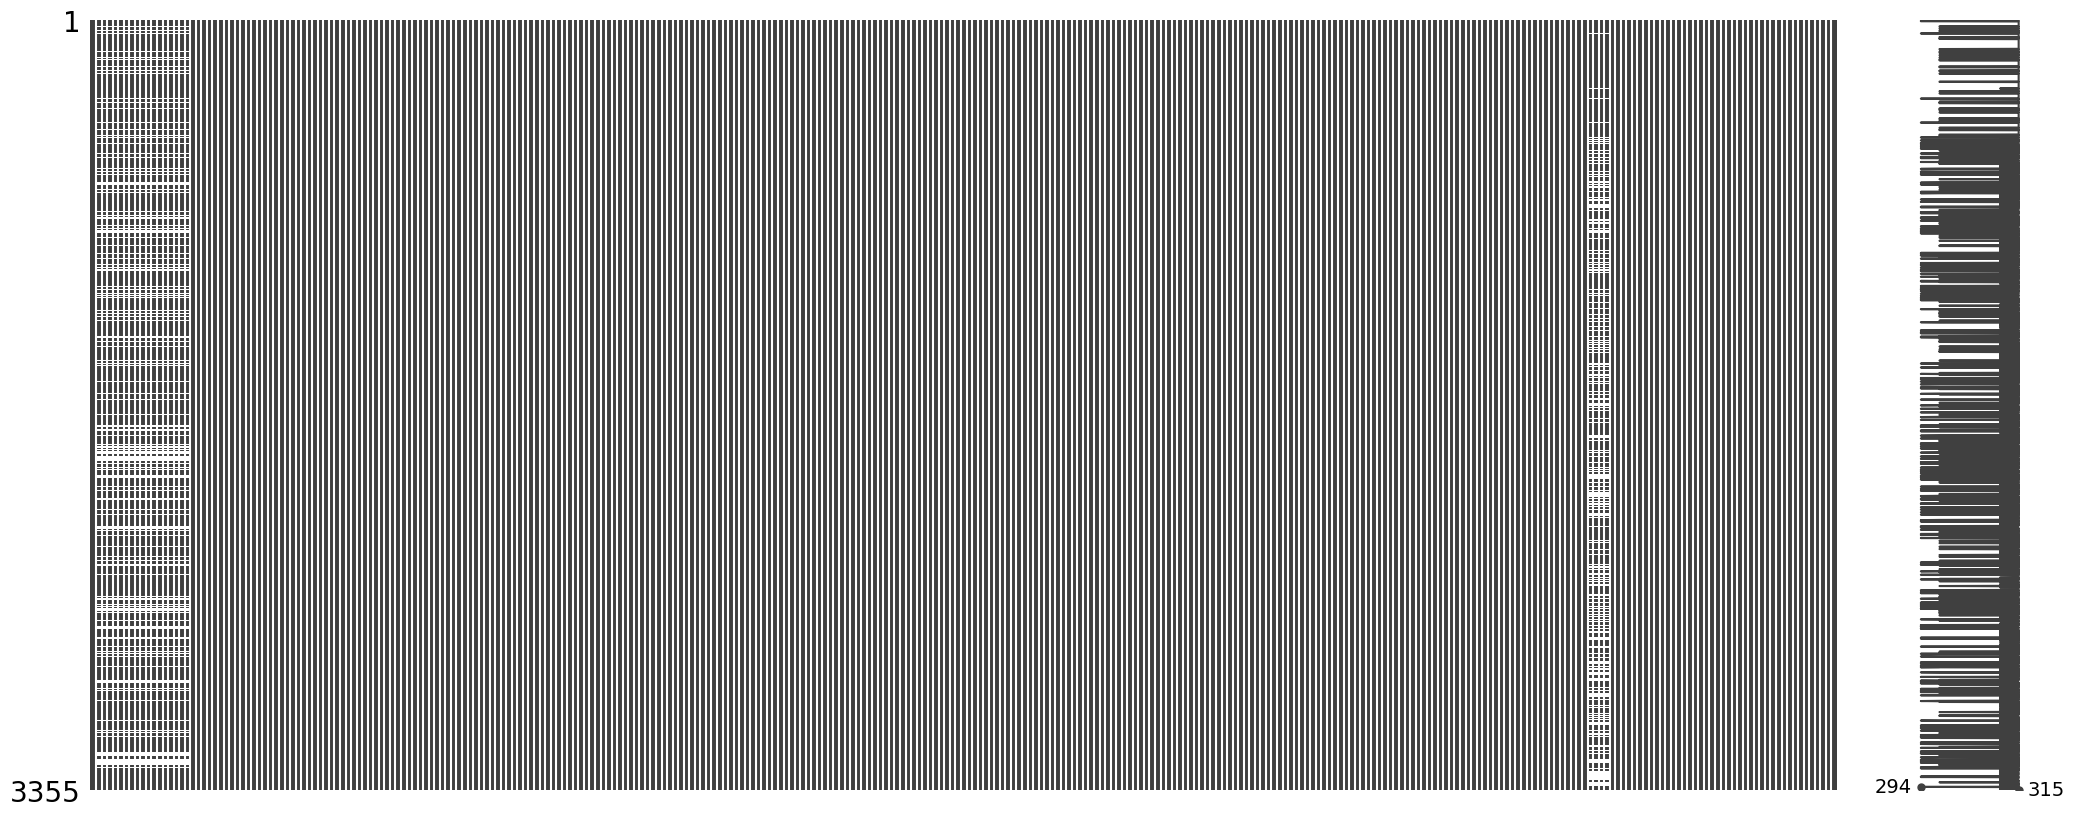

In [108]:
%pip install missingno
import missingno as msno

# plot missing values
msno.matrix(merged_df)

# Questions - 
* DROP where conct values are 0 - no target variable
* Fillna for MjRd with 0 - missing values may imply no major roads, or 
* Impute one or both values with median or mean
* Do we have a threshold for 0 vlaues before we drop the column?
* Do we undertake feature selection or dimensionality reduction?

In [110]:
# if column contains NaN value
# undertake shapiro wilk test to determine if column is normally distributed
# if p value is less than 0.05, column is not normally distributed
# if column is not normally distributed, replace NaN values with median
# if column is normally distributed, replace NaN values with mean
#  use simple imputer to replace NaN values

%pip install scipy
%pip install scikit-learn
import sklearn as sk
from scipy import stats
from sklearn.impute import SimpleImputer

for column in merged_df.columns:
    if merged_df[column].isnull().sum() > 0:
        shapiro_test = stats.shapiro(merged_df[column].dropna())
        if shapiro_test[1] < 0.05:
            imputer = SimpleImputer(missing_values=np.nan, strategy='median')
            merged_df[column] = imputer.fit_transform(merged_df[column].values.reshape(-1, 1))
        else:
            imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
            merged_df[column] = imputer.fit_transform(merged_df[column].values.reshape(-1, 1))




[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<Axes: >

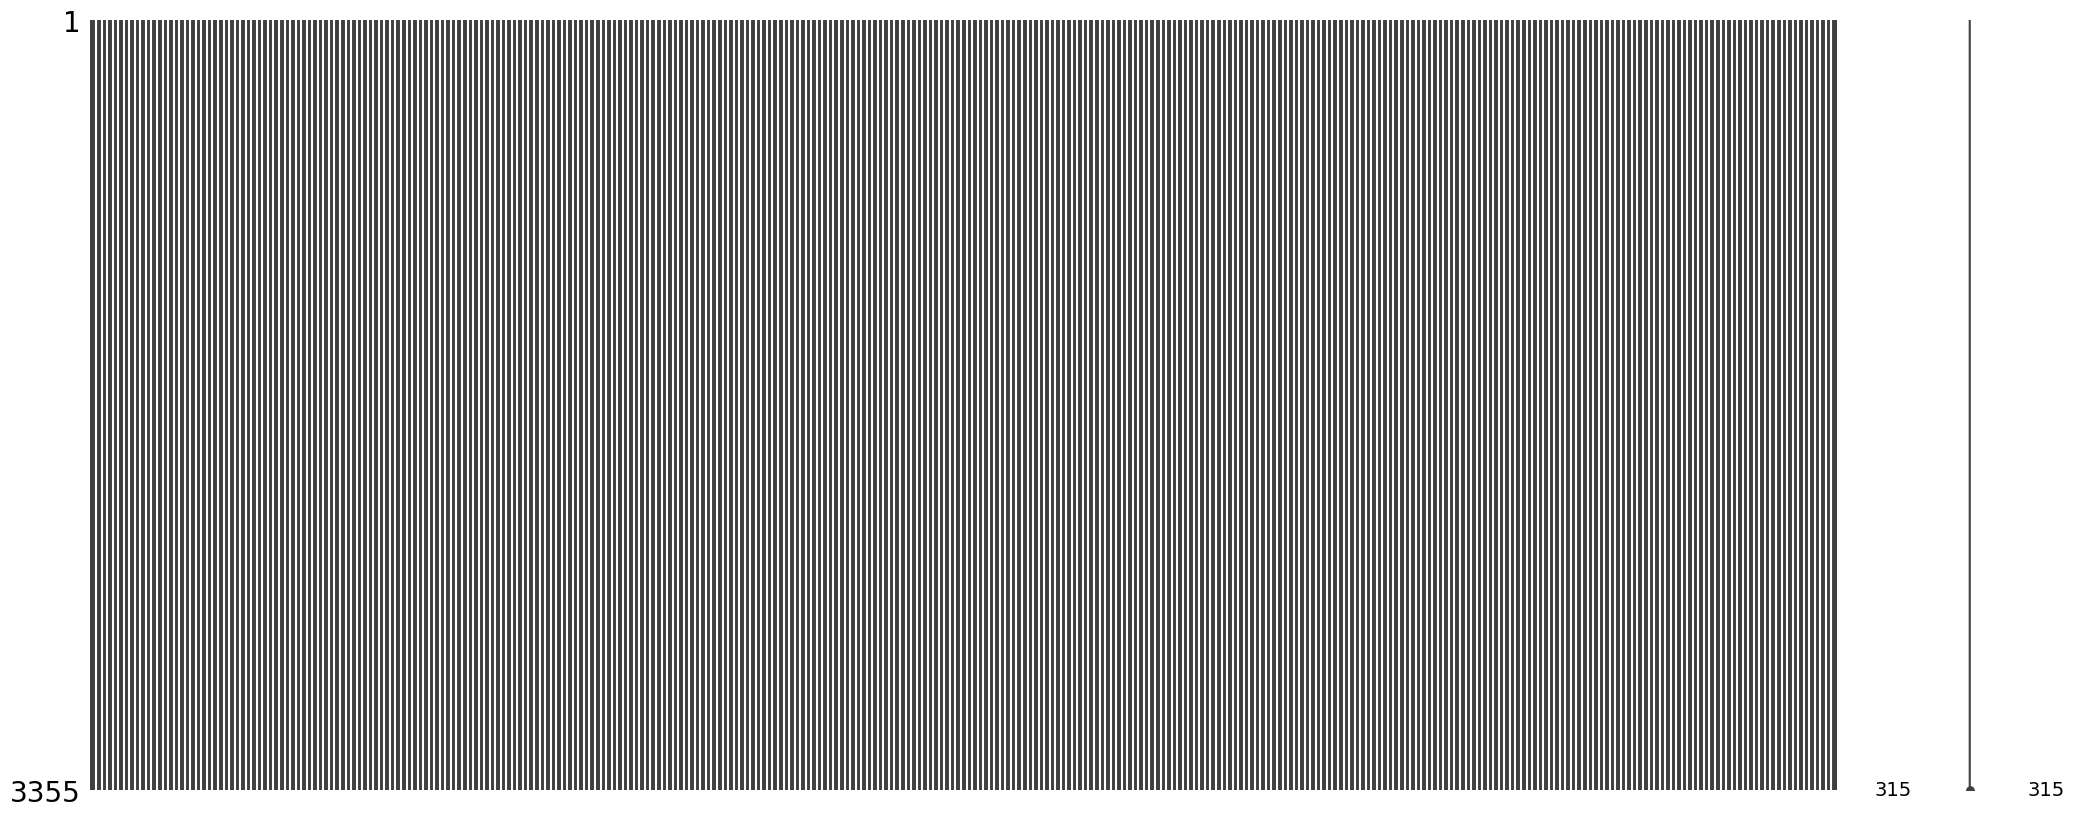

In [111]:
msno.matrix(merged_df)

## Manage Outliers

## Normalise data

* is this model dependent?

#  Feature Selection / Dimensionality Reduction

## Export Clean Dataset